# Lab3 - The problem of over-fitting

---
This notebook contains the code samples found in Section 3.4 and Section 4.4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

---

The fundamental issue in machine learning is the tension between:
 - **Data fitting** - the process of adjusting a model to get the best performance possible on the training data; 
 - **Generalization** - how well the trained model would perform on data it has never seen before. 

At the beginning of training, fitting and generalization are correlated: the lower your loss on training data, the lower your loss on  test data. While this is happening, your model is said to be **under-fit**: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, test metrics stall then start degrading: the model is then starting to **over-fit**. In other words, it is starting to learn patterns  that are specific to the training data but that are misleading or irrelevant when it comes to new data.

The goal is to achieve models that get a good generalization, so as to perform well on never-before-seen data. However, you do not control generalization; you can only adjust the model based on its training data. Therefore, it’s crucial to be able to reliably measure the generalization power of your model.

#### Training, validation, and test sets

Evaluating a model always boils down to splitting the available data into three sets: **training**, **validation**, and **test**. You train on the training data, and evaluate your model on the validation data. Once your model is ready for prime time, you test it one final time on the test data.

*Why do we need separate sets?* 

You should never test a machine learning model on the same data that you used to train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and what you actually care about is your model's performance on new data (since you already know the labels of your training data, obviously you don't need your model to predict those). For instance, it is possible that your model could end up merely *memorizing* a mapping between your training samples and their targets, which would be completely useless for the task of predicting targets for data never seen before. 

*Why not have two sets: a training set and a test set?* 

You’d train on the training data and evaluate on the test data. Much simpler! The reason is that developing a model always involves tuning its configuration: for
example, choosing the number of layers or the size of the layers (called the hyper-parameters of the model, to distinguish them from the parameters, which are the network’s weights). You do this tuning by using as a feedback signal the performance of the model on the validation data. In essence, this tuning is a form of learning: a search
for a good configuration in some parameter space. As a result, tuning the configuration of the model based on its performance on the validation set can quickly result in overfitting to the validation set, even though your model is never directly trained on it.

Central to this phenomenon is the notion of information leaks. Every time you tune a hyperparameter of your model based on the model’s performance on the validation set, some information about the validation data leaks into the model. If you do this only once, for one parameter, then very few bits of information will leak, and your validation
set will remain reliable to evaluate the model. But if you repeat this many times—running one experiment, evaluating on the validation set, and modifying your model as a result — then you’ll leak an increasingly significant amount of information about the validation set into the model.

At the end of the day, you'll end up with a model that performs artificially well on the validation data, because that’s what you optimized it for. You care about performance on completely new data, not the validation data, so you need to use a completely different, never-before-seen, dataset to evaluate the model: the test set. Your model shouldn’t have had access to any information about the test set, even indirectly. If anything about the model has been tuned based on test set performance, then your measure of generalization will be flawed.

Splitting your data into training, validation, and test sets may seem straightforward, but there are a few advanced ways to do it that can come in handy when little data is available. The two classic approaches are: *hold-out* validation, and *K-fold* validation.

#### Things to keep in mind

*Data representativeness* — You want both your training set and test set to be representative of the data at hand. For instance, if you’re trying to classify images of digits, and you’re starting from an array of samples where the samples are ordered by their class, taking the first 80% of the array as your training set and the remaining 20% as your test set will result in your training set containing only classes 0-7, whereas your test set contains only classes 8–9. This seems like a ridiculous mistake, but it’s surprisingly common. For this reason, you usually should randomly shuffle your data before splitting it into training and test sets.

*The arrow of time* — If you’re trying to predict the future given the past (for example, tomorrow’s weather, stock movements, and so on), you should not randomly shuffle your data before splitting it, because doing so will create a temporal leak: your model will effectively be trained on data from the future. In such situations, you should always make sure all data in your test set is posterior to the data in the training set.

*Redundancy in your data* — If some data points in your data appear twice (fairly common with real-world data), then shuffling the data, and splitting it into a training set and a validation set will result in redundancy between the training and validation sets. In effect, you’ll be testing on part of your training data, which is the worst thing you can do! Make sure your training set and validation set are disjoint.

# 1. How to detect over-fitting

We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews. 

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine).

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). Moreover, `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive".

In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000.

For kicks, here's how you can quickly decode one of these reviews back to English words.

In [ ]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

1641221/1641221 [==============================] - 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

## 1.1 Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which is covered in Chapter 6 of the book).

- We could one-hot encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)

# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [ ]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## 1.2 Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected layers with ReLU activations. There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many units to chose for each layer.
 
For the time being, you will use two hidden layers with 16 units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The intermediate layers will use a *ReLU* activation, whereas the final layer will use a *sigmoid* activation. 

---
**Remember**

The ReLU is a function meant to zero-out negative values, whereas the sigmoid is a function that squashes arbitrary values into the `[0, 1]` interval, so as to output something that can be interpreted as a probability (how likely the sample is to have the target "1").


A fully-connected layer with 16 units means that the layer's input data are projected onto a 16-dimensional representation space. You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data, but not on the test data).

---

## ===== Exercise =====

Complete the code below with the Keras implementation of the network. Check out the [documentation](https://keras.io/layers/core/) to get familiar with Keras layers.

In [ ]:
#@title
from keras import models
from keras import layers

model = models.Sequential()

# Layer with 16 units and 'relu' activation
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) # ADD CODE HERE

# Layer with 16 units and 'relu' activation
model.add( layers.Dense(16, activation='relu') ) # AD CODE HERE

# Layer with 1 unit and 'sigmoid' activation (REMARK: sigmoid is for binary classification)
model.add(layers.Dense(1, activation='sigmoid')) # ADD CODE HERE

Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), it is best to use the `binary_crossentropy` loss. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the optimizer and the loss function. Note that we will also monitor accuracy during training.

## ===== Exercise =====

Complete the code below by specifying the `adam` optimizer and the `binary_crossentropy` loss function.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # ADD CODE HERE

## 1.3 Validating your approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data.

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in `partial_x_train` and `partial_y_train`), in mini-batches of 512 samples. At this same time, we will monitor loss and accuracy on the 10,000 samples that we set apart (`x_val` and `y_val`). This is done by passing the validation set as the `validation_data` argument.

## ===== Exercise =====

Complete the code below as follows:
- Use `partial_x_train` and `partial_y_train` as **training data**.


- Set 20 epochs and batchs of size 512.


- Use `(x_val, y_val)` as **validation data**.

In [ ]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val)) # ADD CODE HERE

Epoch 1/20
30/30 [==============================] - 4s 73ms/step - loss: 0.6159 - accuracy: 0.7403 - val_loss: 0.4843 - val_accuracy: 0.8289
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.3626 - accuracy: 0.8825 - val_loss: 0.3194 - val_accuracy: 0.8846
Epoch 3/20
30/30 [==============================] - 1s 35ms/step - loss: 0.2335 - accuracy: 0.9244 - val_loss: 0.2808 - val_accuracy: 0.8898
Epoch 4/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1733 - accuracy: 0.9454 - val_loss: 0.2762 - val_accuracy: 0.8883
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1341 - accuracy: 0.9595 - val_loss: 0.2842 - val_accuracy: 0.8878
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1049 - accuracy: 0.9711 - val_loss: 0.3004 - val_accuracy: 0.8844
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0810 - accuracy: 0.9803 - val_loss: 0.3216 - val_accuracy: 0.8803
Epoch 8/20
30

On CPU, this will take a few seconds per epoch: training is over in a couple of minutes. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. It contains 4 entries: one per metric that was being monitored, during training and during test. Let's use Matplotlib to plot the training and test loss side by side, as well as the training and test accuracy.

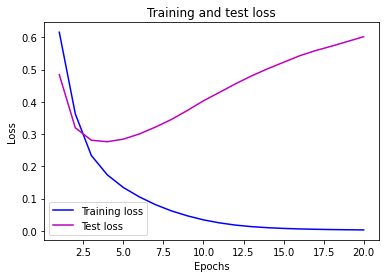

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, linestyle='-', color='b', label='Training loss')
plt.plot(epochs, test_loss, linestyle='-', color='m', label='Test loss')

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

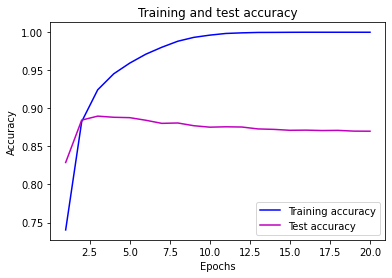

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs,  test_acc, 'm', label='Test accuracy')

plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization: the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the test loss and accuracy: they seem to peak after few epochs. This is an example of what we were warning against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you are seeing is **over-fitting**: after few epochs, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to new data (i.e., data outside of the training set).

## 1.4 Testing on new data

After having trained a network, you will want to use it on new data. You can generate the likelihood of reviews being positive by using the `predict` method. As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).

In [ ]:
proba = model.predict(x_test)

print(proba.shape)

782/782 [==============================] - 2s 2ms/step
(25000, 1)


Moreover, you can evaluate the network on our test data by using the `evaluate` method.

In [ ]:
results = model.evaluate(x_test, y_test)

print()
print("Test accuracy: {:2.2f}%".format(results[1]*100))

782/782 [==============================] - 2s 2ms/step - loss: 0.6502 - accuracy: 0.8574

Test accuracy: 85.74%


We need to clean the memory before building the other networks, as this takes a lot of memory

In [ ]:
import tensorflow as tf
import gc
tf.keras.backend.clear_session()
del model
gc.collect()

841

Our over-fitted network achieves an accuracy of 85%. In this case, to prevent overfitting, we could simply stop training after few epochs. This is called **early stopping**. So, let's train a new network from scratch, then evaluate it on our test data.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

print()
print("Test accuracy: {:2.2f}%".format(results[1]*100))

Epoch 1/4
49/49 [==============================] - 2s 31ms/step - loss: 0.5554 - accuracy: 0.7366
Epoch 2/4
49/49 [==============================] - 2s 37ms/step - loss: 0.2847 - accuracy: 0.9052
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.1938 - accuracy: 0.9321
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3058 - accuracy: 0.8817

Test accuracy: 88.17%


Early stopping allows us to achieve an accuracy of 88%, striking an improvement of 3%. 

In general, there is a range of techniques we can leverage to mitigate overfitting, which are covered in the following.

Clean the memory again

In [ ]:
tf.keras.backend.clear_session()
del model
gc.collect()

1610

# 2. How to fight against over-fitting

In the previous example, we could notice that the performance of our model on the test data peaked after a few epochs, and then started degrading. This clearly indicated that our model *overfitted* to the training data. The problem of overfitting happens in every single machine learning task. Learning how to deal with overfitting is essential to mastering machine learning. 

To prevent a model from over-fitting (i.e., learning misleading or irrelevant patterns found in the training data), the best solution is to *get more training data*. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The process of fighting overfitting in this way is called *regularization*. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model from the previous tutorial.

## 2.1 Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set), in order to find the right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the validation loss.

Let's try this on our movie review classification network. Our original network was as such. 

---
**Note:** We will be using the test set as our validation set. It doesn't matter in this context.

---

In [ ]:
original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

original_hist = original_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 63ms/step - loss: 0.4843 - acc: 0.8136 - val_loss: 0.3442 - val_acc: 0.8728
Epoch 2/20
49/49 [==============================] - 3s 54ms/step - loss: 0.2565 - acc: 0.9102 - val_loss: 0.2875 - val_acc: 0.8853
Epoch 3/20
49/49 [==============================] - 2s 44ms/step - loss: 0.1891 - acc: 0.9338 - val_loss: 0.2863 - val_acc: 0.8859
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1503 - acc: 0.9490 - val_loss: 0.3030 - val_acc: 0.8818
Epoch 5/20
49/49 [==============================] - 2s 36ms/step - loss: 0.1225 - acc: 0.9594 - val_loss: 0.3275 - val_acc: 0.8777
Epoch 6/20
49/49 [==============================] - 2s 35ms/step - loss: 0.1004 - acc: 0.9694 - val_loss: 0.3574 - val_acc: 0.8716
Epoch 7/20
49/49 [==============================] - 2s 38ms/step - loss: 0.0806 - acc: 0.9774 - val_loss: 0.3917 - val_acc: 0.8677
Epoch 8/20
49/49 [==============================] - 3s 52ms/step - loss: 0.0635 - a

In [ ]:
# Clean the memory
tf.keras.backend.clear_session()
del original_model
gc.collect()

2805

## ===== Exercise =====

Now let's try to replace it with this smaller network:
 - First layer with 4 units and 'relu' activation. *Don't forget to set the input shape!*
 
 
 - Second layer with 4 units and 'relu' activation.
 
 
 - Output layer with 1 unit and 'sigmoid' activation.
 
 
 - Loss function is binary crossentropy.

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,))) # ADD CODE HERE
smaller_model.add(layers.Dense(4, activation='relu')) # ADD CODE HERE
smaller_model.add(layers.Dense(1, activation='sigmoid')) # ADD CODE HEER

smaller_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # ADD CODE HERE

smaller_model_hist = smaller_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 71ms/step - loss: 0.5770 - acc: 0.7612 - val_loss: 0.4746 - val_acc: 0.8575
Epoch 2/20
49/49 [==============================] - 2s 37ms/step - loss: 0.3849 - acc: 0.8890 - val_loss: 0.3640 - val_acc: 0.8768
Epoch 3/20
49/49 [==============================] - 2s 34ms/step - loss: 0.2910 - acc: 0.9088 - val_loss: 0.3169 - val_acc: 0.8824
Epoch 4/20
49/49 [==============================] - 2s 34ms/step - loss: 0.2386 - acc: 0.9242 - val_loss: 0.2934 - val_acc: 0.8871
Epoch 5/20
49/49 [==============================] - 2s 50ms/step - loss: 0.2050 - acc: 0.9335 - val_loss: 0.2849 - val_acc: 0.8878
Epoch 6/20
49/49 [==============================] - 2s 44ms/step - loss: 0.1814 - acc: 0.9412 - val_loss: 0.2842 - val_acc: 0.8860
Epoch 7/20
49/49 [==============================] - 2s 34ms/step - loss: 0.1616 - acc: 0.9474 - val_loss: 0.2898 - val_acc: 0.8836
Epoch 8/20
49/49 [==============================] - 2s 37ms/step - loss: 0.1467 - a

In [ ]:
# Clean memory
tf.keras.backend.clear_session()
del smaller_model
gc.collect()

1609

Here's a comparison of the test losses of the original network and the smaller network. (*Remember:* a lower test loss indicates a better model.)

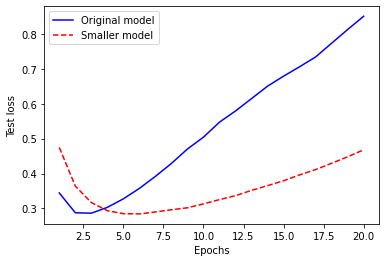

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

plt.plot(epochs, original_hist.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, smaller_model_hist.history['val_loss'], linestyle='--', color='r', label='Smaller model')

plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()

As you can see, the smaller network starts overfitting later than the original one, and its performance degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant.

In [ ]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

bigger_model_hist = bigger_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 19s 371ms/step - loss: 0.3547 - acc: 0.8408 - val_loss: 0.2939 - val_acc: 0.8801
Epoch 2/20
49/49 [==============================] - 22s 456ms/step - loss: 0.1445 - acc: 0.9477 - val_loss: 0.3199 - val_acc: 0.8750
Epoch 3/20
49/49 [==============================] - 22s 458ms/step - loss: 0.0460 - acc: 0.9871 - val_loss: 0.4734 - val_acc: 0.8619
Epoch 4/20
49/49 [==============================] - 17s 350ms/step - loss: 0.0074 - acc: 0.9988 - val_loss: 0.5895 - val_acc: 0.8706
Epoch 5/20
49/49 [==============================] - 23s 474ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6790 - val_acc: 0.8700
Epoch 6/20
49/49 [==============================] - 17s 353ms/step - loss: 6.3683e-04 - acc: 1.0000 - val_loss: 0.7192 - val_acc: 0.8695
Epoch 7/20
49/49 [==============================] - 22s 450ms/step - loss: 1.4642e-04 - acc: 1.0000 - val_loss: 0.7533 - val_acc: 0.8693
Epoch 8/20
49/49 [==============================] - 17s 342ms

Here's how the bigger network fares compared to the other ones.

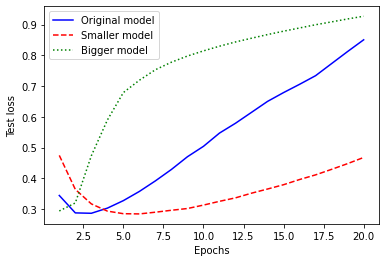

In [ ]:
plt.plot(epochs, original_hist.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, smaller_model_hist.history['val_loss'], linestyle='--', color='r', label='Smaller model')

plt.plot(epochs, bigger_model_hist.history['val_loss'], linestyle=':', color='g', label='Bigger model')

plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away and much more severely.

Meanwhile, here are the training losses for our two networks:

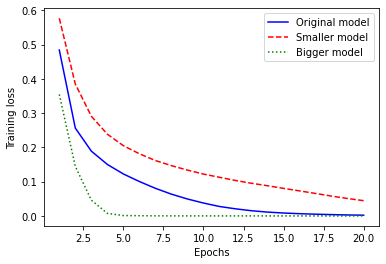

In [ ]:
plt.plot(epochs, original_hist.history['loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, smaller_model_hist.history['loss'], linestyle='--', color='r', label='Smaller model')

plt.plot(epochs, bigger_model_hist.history['loss'], linestyle=':', color='g', label='Bigger model')

plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and test losses).

In [ ]:
#Clean memory
tf.keras.backend.clear_session()
del bigger_model
gc.collect()

12436

## 2.2 Norm penalization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called *norm penalization*, and it is done by adding to the loss function of the network a cost associated with having large weights. This  cost comes in two flavors:

- *L1-norm penalization*, where the cost added is proportional to the absolute value of the weights coefficients.
- *L2-norm penalization*, where the cost added is proportional to the square of the value of the weights coefficients. 

Let's add a L2-norm penalization to our movie review classification network.

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

l2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Hereabove, `l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2-norm penalization.

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 104ms/step - loss: 0.5318 - acc: 0.8024 - val_loss: 0.4024 - val_acc: 0.8784
Epoch 2/20
49/49 [==============================] - 2s 39ms/step - loss: 0.3335 - acc: 0.9006 - val_loss: 0.3398 - val_acc: 0.8875
Epoch 3/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2767 - acc: 0.9164 - val_loss: 0.3298 - val_acc: 0.8866
Epoch 4/20
49/49 [==============================] - 2s 37ms/step - loss: 0.2506 - acc: 0.9268 - val_loss: 0.3281 - val_acc: 0.8874
Epoch 5/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2331 - acc: 0.9352 - val_loss: 0.3353 - val_acc: 0.8844
Epoch 6/20
49/49 [==============================] - 3s 64ms/step - loss: 0.2259 - acc: 0.9363 - val_loss: 0.3447 - val_acc: 0.8821
Epoch 7/20
49/49 [==============================] - 2s 37ms/step - loss: 0.2158 - acc: 0.9421 - val_loss: 0.3675 - val_acc: 0.8762
Epoch 8/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2119 - 

In [ ]:
#Clean memory
tf.keras.backend.clear_session()
del l2_model
gc.collect()

1610

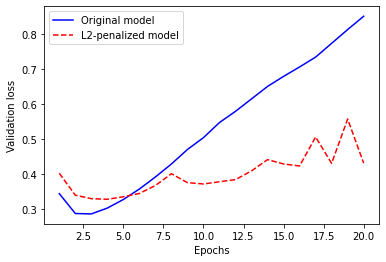

In [ ]:
plt.plot(epochs, original_hist.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, l2_model_hist.history['val_loss'], linestyle='--', color='r', label='L2-penalized model')

plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the model with L2-norm penalization has become much more resistant to overfitting than the original model, even though both models have the same number of parameters.

As alternatives to L2-norm regularization, you could use one of the following Keras weight regularizers.

In [ ]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001);

## 2.3 Dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks. Applied to a layer, it consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Its author, Geoff Hinton, has said that he was inspired, among other things, by a fraud prevention mechanism used by banks -- in his own words: *"I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting"*.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras, you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it. Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting.

## ===== Exercise =====

Complete the code below by adding [`Dropout`](https://keras.io/api/layers/regularization_layers/dropout/) layers with `rate=0.5`.

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5)) # ADD CODE HERE
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5)) # ADD CODE HERE
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

dpt_model_hist = dpt_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 7s 132ms/step - loss: 0.6345 - acc: 0.6638 - val_loss: 0.5310 - val_acc: 0.8334
Epoch 2/20
49/49 [==============================] - 4s 79ms/step - loss: 0.4897 - acc: 0.7938 - val_loss: 0.3833 - val_acc: 0.8766
Epoch 3/20
49/49 [==============================] - 3s 62ms/step - loss: 0.3914 - acc: 0.8562 - val_loss: 0.3168 - val_acc: 0.8811
Epoch 4/20
49/49 [==============================] - 8s 170ms/step - loss: 0.3280 - acc: 0.8846 - val_loss: 0.2886 - val_acc: 0.8874
Epoch 5/20
49/49 [==============================] - 3s 62ms/step - loss: 0.2857 - acc: 0.9048 - val_loss: 0.2800 - val_acc: 0.8880
Epoch 6/20
49/49 [==============================] - 3s 62ms/step - loss: 0.2513 - acc: 0.9144 - val_loss: 0.2868 - val_acc: 0.8873
Epoch 7/20
49/49 [==============================] - 3s 69ms/step - loss: 0.2284 - acc: 0.9247 - val_loss: 0.2985 - val_acc: 0.8874
Epoch 8/20
49/49 [==============================] - 3s 62ms/step - loss: 0.2078 -

Let's plot the results.

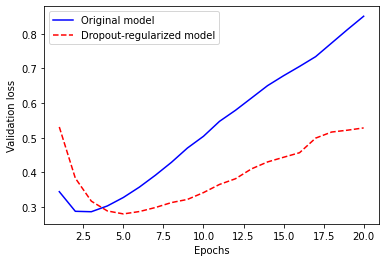

In [ ]:
plt.plot(epochs, original_hist.history['val_loss'], linestyle='-', color='b', label='Original model')

plt.plot(epochs, dpt_model_hist.history['val_loss'], linestyle='--', color='r', label='Dropout-regularized model')

plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Again, a clear improvement over the original network.

# 3. Conclusion

To recap, here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Stopping the training early.
* Adding norm penalization.
* Adding dropout.

---